In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image

# --- Paths and Configuration ---
ROOT = r"/home/msi/Documents/IIT-H/src"
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks")
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier_mask_only.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8
num_epochs = 20
learning_rate = 1e-4

# --- Dataset ---
class MaskDataset(Dataset):
    def __init__(self, mask_dir, label, transform=None):
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mask_path = os.path.join(self.mask_dir, self.files[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            mask = Image.fromarray(mask).resize(input_size)
            mask = self.transform(mask)
        y = torch.tensor([self.label], dtype=torch.float32)
        return mask, y

# --- Transforms ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoaders ---
good_dataset = MaskDataset(GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = MaskDataset(BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Model ---
def get_model():
    try:
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    except AttributeError:
        model = models.resnext50_32x4d(pretrained=True)

    # Modify first conv for 1-channel input
    orig_conv = model.conv1
    model.conv1 = nn.Conv2d(
        1, orig_conv.out_channels, kernel_size=orig_conv.kernel_size,
        stride=orig_conv.stride, padding=orig_conv.padding, bias=orig_conv.bias
    )
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last two residual layers and final fc
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

model = get_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# --- Training Loop ---
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds.squeeze() == y_batch.squeeze()).sum().item()
        total += x_batch.size(0)
    train_acc = correct / total
    train_loss = total_loss / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds.squeeze() == y_val.squeeze()).sum().item()
            total += x_val.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVED_CLASSIFIER_PATH)
        print("Saved best model!")

print("Training complete. Best validation accuracy:", best_val_acc)


Epoch 1/20 | Train Loss: 0.3453 | Train Acc: 0.8688 | Val Acc: 0.9417
Saved best model!
Epoch 2/20 | Train Loss: 0.1909 | Train Acc: 0.9250 | Val Acc: 0.9583
Saved best model!
Epoch 3/20 | Train Loss: 0.1686 | Train Acc: 0.9396 | Val Acc: 0.9333
Epoch 4/20 | Train Loss: 0.1138 | Train Acc: 0.9646 | Val Acc: 0.9750
Saved best model!
Epoch 5/20 | Train Loss: 0.1193 | Train Acc: 0.9583 | Val Acc: 0.9833
Saved best model!
Epoch 6/20 | Train Loss: 0.0599 | Train Acc: 0.9729 | Val Acc: 0.9333
Epoch 7/20 | Train Loss: 0.0347 | Train Acc: 0.9875 | Val Acc: 0.9667
Epoch 8/20 | Train Loss: 0.0688 | Train Acc: 0.9833 | Val Acc: 0.9750
Epoch 9/20 | Train Loss: 0.0715 | Train Acc: 0.9792 | Val Acc: 0.9833
Epoch 10/20 | Train Loss: 0.0571 | Train Acc: 0.9792 | Val Acc: 0.9500
Epoch 11/20 | Train Loss: 0.0363 | Train Acc: 0.9938 | Val Acc: 0.9750
Epoch 12/20 | Train Loss: 0.0406 | Train Acc: 0.9875 | Val Acc: 0.9333
Epoch 13/20 | Train Loss: 0.0618 | Train Acc: 0.9688 | Val Acc: 0.9417
Epoch 14/20 | 

Loading 1-channel mask classifier...


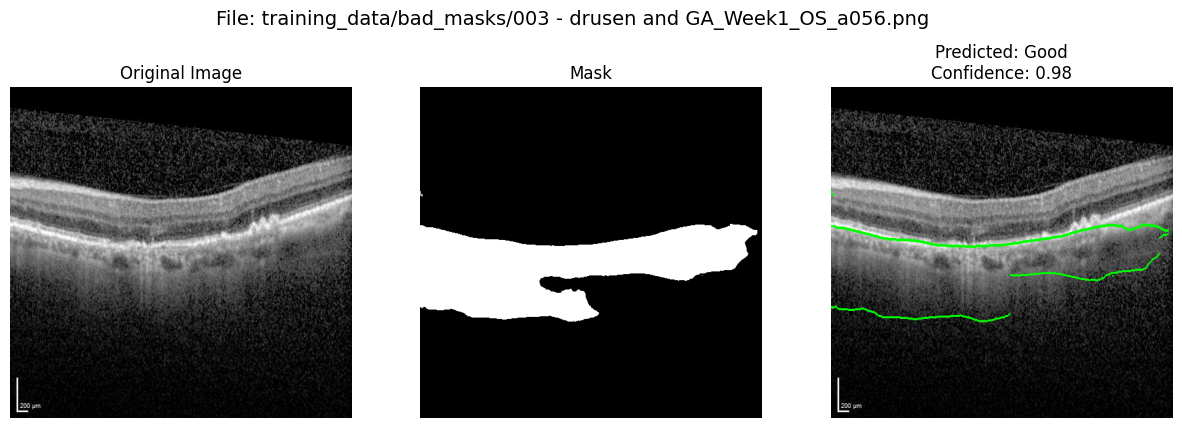

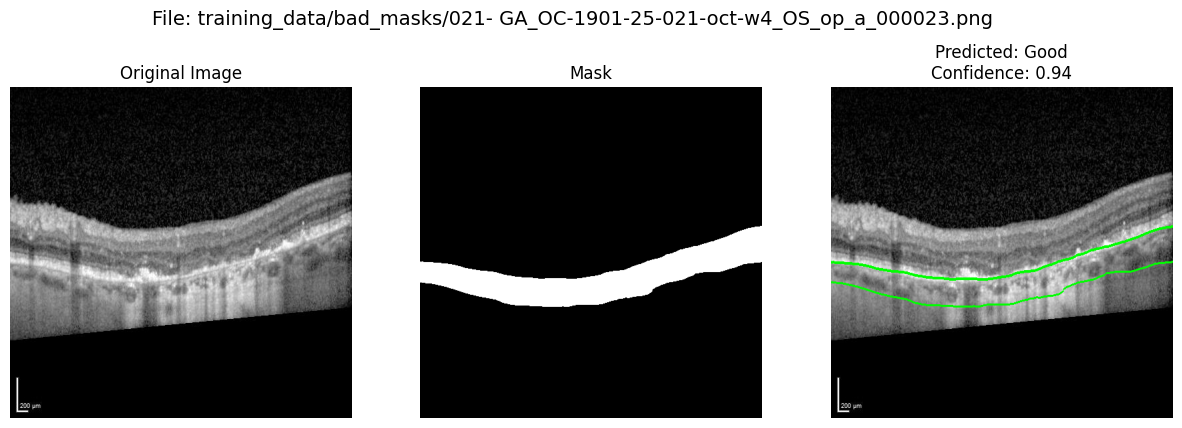

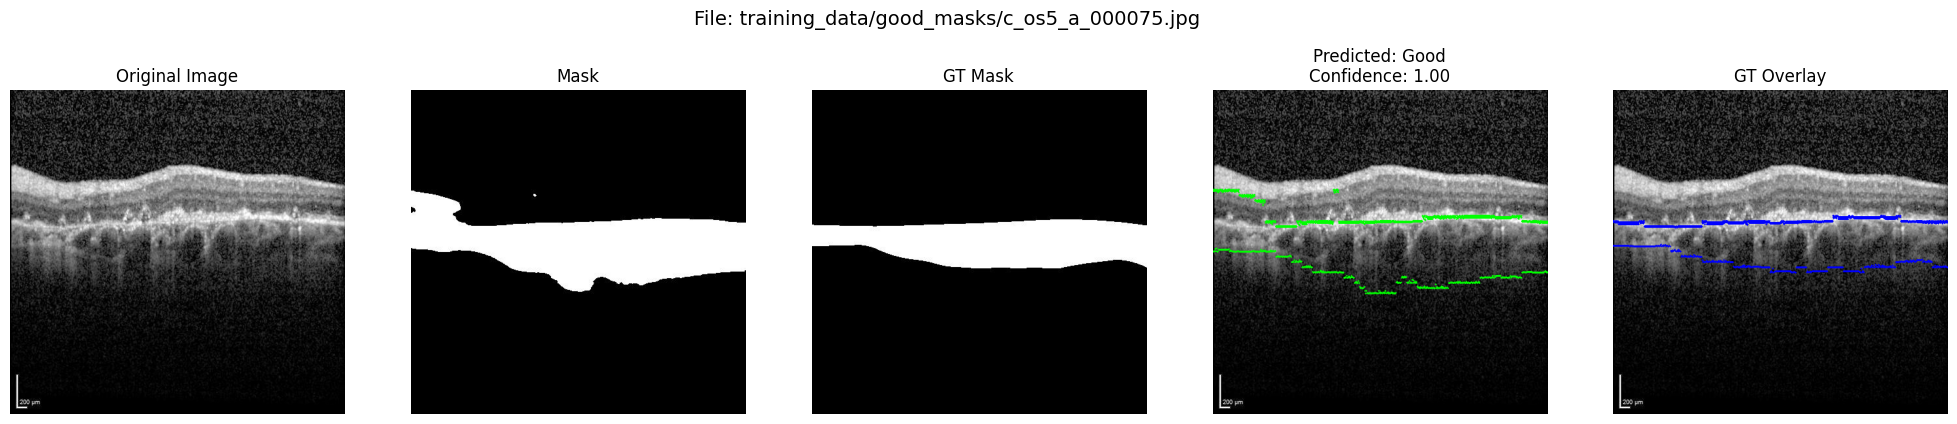

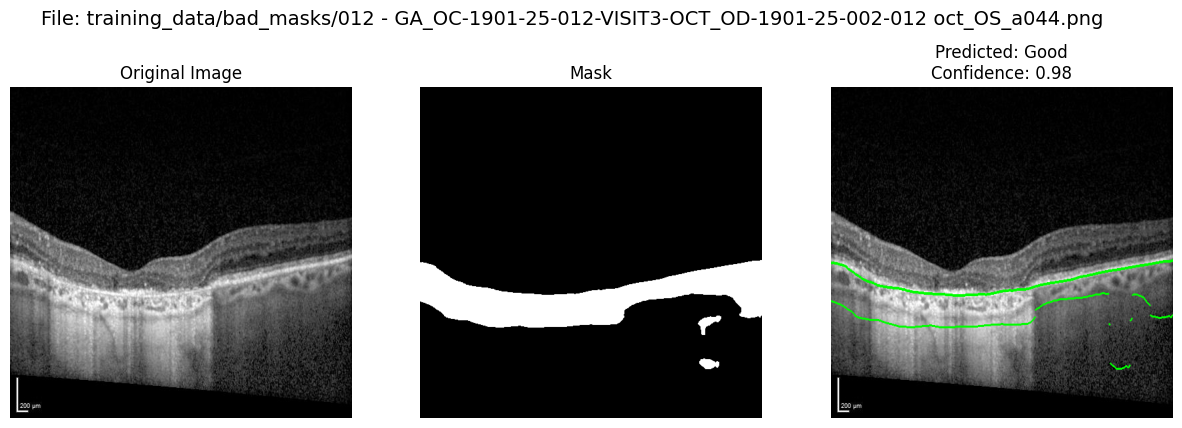

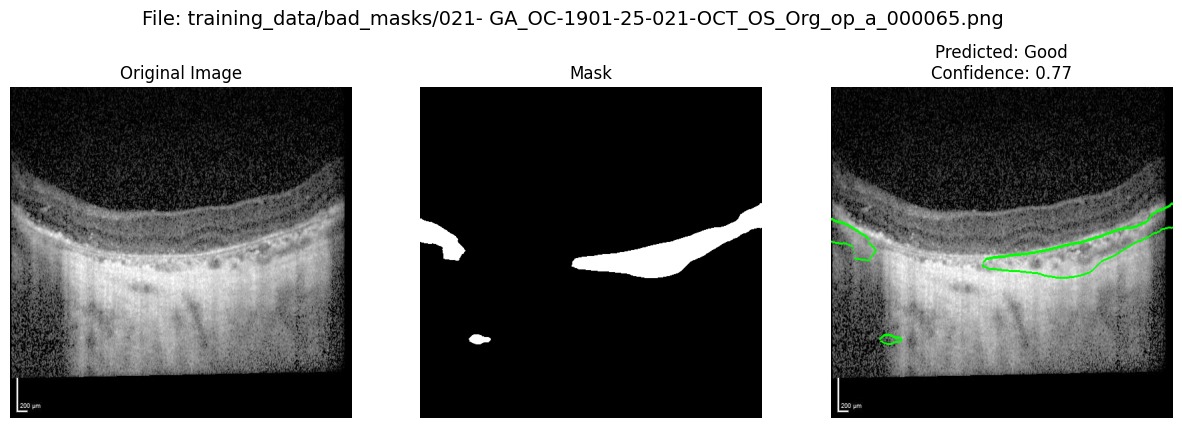

In [4]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

# --- Paths and Configuration ---
ROOT = r"/home/msi/Documents/IIT-H/src"
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier_mask_only.pth")
GOOD_IMAGES_DIR = os.path.join(ROOT, "training_data", "good_images")
BAD_IMAGES_DIR = os.path.join(ROOT, "training_data", "bad_images")
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks")
GT_MASK_DIR = os.path.join(ROOT, "training_data", "gt_masks_good")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)

# -------------------------------
# Load Mask-only Classifier
# -------------------------------
def get_mask_classifier(path, device):
    print("Loading 1-channel mask classifier...")
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

    # Adjust first conv layer for 1-channel input
    orig_conv1 = model.conv1
    model.conv1 = nn.Conv2d(1, orig_conv1.out_channels, 
                            kernel_size=orig_conv1.kernel_size,
                            stride=orig_conv1.stride,
                            padding=orig_conv1.padding,
                            bias=orig_conv1.bias)
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv1.weight[:, 0, :, :]
    
    # Final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)

    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device).eval()
    return model

# -------------------------------
# Utilities
# -------------------------------
def create_boundaries(mask, first_only=False):
    h, w = mask.shape
    boundary = np.zeros_like(mask)
    for col in range(w):
        indices = np.where(mask[:, col] > 0)[0]
        if indices.size > 0:
            boundary[indices[0], col] = 255
            if not first_only and indices.size > 1:
                boundary[indices[1], col] = 255
                boundary[indices[-1], col] = 255
    return boundary

def preprocess_mask_and_image(mask_path, is_good=True):
    filename = os.path.basename(mask_path)
    # Load original image
    img_path = os.path.join(GOOD_IMAGES_DIR if is_good else BAD_IMAGES_DIR, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, input_size)
    img_tensor = transforms.ToTensor()(img_resized)

    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, input_size)
    mask_tensor = transforms.ToTensor()(mask_resized)

    return img_tensor, mask_tensor, img, mask

def get_gt_mask(filename):
    gt_path = os.path.join(GT_MASK_DIR, filename)
    if os.path.exists(gt_path):
        return cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    return None

# -------------------------------
# Main pipeline
# -------------------------------
def run_pipeline(mask_paths, classifier_model, is_good_flags):
    for mask_path, is_good in zip(mask_paths, is_good_flags):
        filename = os.path.basename(mask_path)
        img_tensor, mask_tensor, original_img, original_mask = preprocess_mask_and_image(mask_path, is_good)

        # 1-channel input
        input_1ch = mask_tensor.unsqueeze(0).to(device)

        # Classifier prediction
        with torch.no_grad():
            out = classifier_model(input_1ch)
            prob = torch.sigmoid(out).item()
            label = "Good" if prob > 0.5 else "Bad"
            confidence = prob if prob > 0.5 else 1 - prob

        # Overlay mask boundaries on original image
        boundary = create_boundaries(original_mask)
        overlay_mask = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
        ys, xs = np.where(boundary == 255)
        for y, x in zip(ys, xs):
            cv2.circle(overlay_mask, (x, y), 1, (0, 255, 0), -1)  # green for mask

        # Check for GT mask
        gt_mask = get_gt_mask(filename) if is_good else None
        overlay_gt = None
        if gt_mask is not None:
            overlay_gt = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
            boundary_gt = create_boundaries(gt_mask)
            ys, xs = np.where(boundary_gt == 255)
            for y, x in zip(ys, xs):
                cv2.circle(overlay_gt, (x, y), 1, (0, 0, 255), -1)  # red for GT

        # Display results
        if overlay_gt is not None:
            n_cols = 5
            fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(original_mask, cmap='gray')
            axes[1].set_title("Mask")
            axes[1].axis('off')

            axes[2].imshow(gt_mask, cmap='gray')
            axes[2].set_title("GT Mask")
            axes[2].axis('off')

            axes[3].imshow(overlay_mask)
            axes[3].set_title(f"Predicted: {label}\nConfidence: {confidence:.2f}")
            axes[3].axis('off')

            axes[4].imshow(overlay_gt)
            axes[4].set_title("GT Overlay")
            axes[4].axis('off')
        else:
            n_cols = 3
            fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(original_mask, cmap='gray')
            axes[1].set_title("Mask")
            axes[1].axis('off')

            axes[2].imshow(overlay_mask)
            axes[2].set_title(f"Predicted: {label}\nConfidence: {confidence:.2f}")
            axes[2].axis('off')

        plt.suptitle(f"File: {os.path.relpath(mask_path, ROOT)}", fontsize=14)
        plt.show()

# -------------------------------
# Gather mask paths
# -------------------------------
good_mask_files = [os.path.join(GOOD_MASKS_DIR, f) 
                   for f in os.listdir(GOOD_MASKS_DIR) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
bad_mask_files = [os.path.join(BAD_MASKS_DIR, f) 
                  for f in os.listdir(BAD_MASKS_DIR) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Combine and create flags
all_mask_files = good_mask_files + bad_mask_files
is_good_flags = [True]*len(good_mask_files) + [False]*len(bad_mask_files)

# -------------------------------
# Run
# -------------------------------
classifier_model = get_mask_classifier(SAVED_CLASSIFIER_PATH, device)

# Random 5 masks for demo (good + bad)
demo_indices = random.sample(range(len(all_mask_files)), min(5, len(all_mask_files)))
demo_masks = [all_mask_files[i] for i in demo_indices]
demo_flags = [is_good_flags[i] for i in demo_indices]

run_pipeline(demo_masks, classifier_model, demo_flags)


In [1]:
import os
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np

# --- Paths and Config ---
ROOT = r"/home/msi/Documents/IIT-H/src"
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks_all")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks_all")
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier_mask_only.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8

# --- Dataset ---
class MaskOnlyDataset(Dataset):
    def __init__(self, mask_dir, label, transform=None):
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mask_filename = self.files[idx]
        mask_path = os.path.join(self.mask_dir, mask_filename)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        if self.transform:
            mask = Image.fromarray(mask).resize(input_size)
            mask = self.transform(mask)

        y = torch.tensor([self.label], dtype=torch.float32)
        return mask, y

# --- Transform ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoader ---
good_dataset = MaskOnlyDataset(GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = MaskOnlyDataset(BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset
val_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# --- Load Model ---
def get_mask_model():
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    orig_conv = model.conv1
    # Change first conv to single channel for mask input
    model.conv1 = torch.nn.Conv2d(1, orig_conv.out_channels,
                                  kernel_size=orig_conv.kernel_size,
                                  stride=orig_conv.stride,
                                  padding=orig_conv.padding,
                                  bias=orig_conv.bias)
    with torch.no_grad():
        # Copy original weights (use first channel)
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(SAVED_CLASSIFIER_PATH, map_location=device))
    model.to(device).eval()
    return model

model = get_mask_model()

# --- Evaluation Loop ---
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_preds.extend(preds)
        all_labels.extend(y_batch.squeeze().cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Compute Metrics ---
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy:         {accuracy:.4f}")
print(f"Precision:        {precision:.4f}")
print(f"Recall:           {recall:.4f}")
print(f"F1 Score:         {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy:         0.1708
Precision:        0.1692
Recall:           1.0000
F1 Score:         0.2894
Confusion Matrix:
[[   4 1709]
 [   0  348]]


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Compute metrics for both classes
precision_per_class = precision_score(all_labels, all_preds, average=None)  # [class 0, class 1]
recall_per_class    = recall_score(all_labels, all_preds, average=None)
f1_per_class        = f1_score(all_labels, all_preds, average=None)

# Macro averages
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro    = recall_score(all_labels, all_preds, average='macro')
f1_macro        = f1_score(all_labels, all_preds, average='macro')

# Accuracy (overall)
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Accuracy: {accuracy:.4f}\n")
print("Per-class Metrics:")
print(f"Class 0 (Good Images) - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1: {f1_per_class[0]:.4f}")
print(f"Class 1 (Bad Images) - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1: {f1_per_class[1]:.4f}\n")
print("Macro-Average Metrics:")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1 Score (macro):  {f1_macro:.4f}\n")
print("Confusion Matrix:")
print(conf_matrix)


Overall Accuracy: 0.1708

Per-class Metrics:
Class 0 (Good Images) - Precision: 1.0000, Recall: 0.0023, F1: 0.0047
Class 1 (Bad Images) - Precision: 0.1692, Recall: 1.0000, F1: 0.2894

Macro-Average Metrics:
Precision (macro): 0.5846
Recall (macro):    0.5012
F1 Score (macro):  0.1470

Confusion Matrix:
[[   4 1709]
 [   0  348]]


In [5]:
import torch
import numpy as np

# --- Hook to capture penultimate features ---
features_list = []

def hook_fn(module, input, output):
    # If output has spatial dimensions, average pool to get one vector per sample
    if output.dim() > 2:
        output = output.mean(dim=[2, 3])  # Global average pooling over H, W
    features_list.append(output.detach().cpu())

# Attach hook to the layer just before the final FC
model.fc.register_forward_hook(hook_fn)

# --- Run data through model ---
with torch.no_grad():
    for x_batch, _ in val_loader:
        x_batch = x_batch.to(device)
        _ = model(x_batch)

# Concatenate all features
all_features = torch.cat(features_list, dim=0).numpy()

# --- Split by class for MCD calculation ---
labels = np.array([y.item() for _, y in full_dataset])
class0_features = all_features[labels == 0]
class1_features = all_features[labels == 1]

# Compute Mean Cluster Difference (Euclidean distance between class means)
mean0 = class0_features.mean(axis=0)
mean1 = class1_features.mean(axis=0)
mcd = np.linalg.norm(mean0 - mean1)

print(f"Mean Cluster Difference (mask-only model): {mcd:.4f}")


Mean Cluster Difference (mask-only model): 3.4981


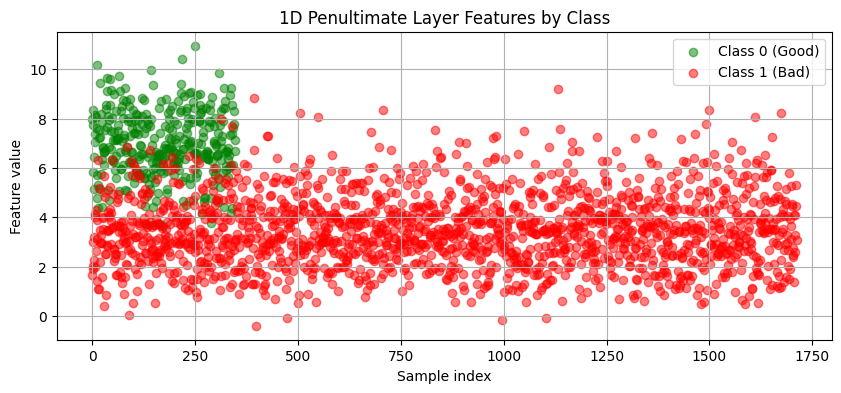

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# all_features: (N,1)
# all_labels: (N,)

# Split by class
class0_features = all_features[all_labels == 1].flatten()
class1_features = all_features[all_labels == 0].flatten()

# Plot
plt.figure(figsize=(10,4))
plt.scatter(np.arange(len(class0_features)), class0_features, color='green', alpha=0.5, label='Class 0 (Good)')
plt.scatter(np.arange(len(class1_features)), class1_features, color='red', alpha=0.5, label='Class 1 (Bad)')
plt.xlabel('Sample index')
plt.ylabel('Feature value')
plt.title('1D Penultimate Layer Features by Class')
plt.legend()
plt.grid(True)
plt.show()

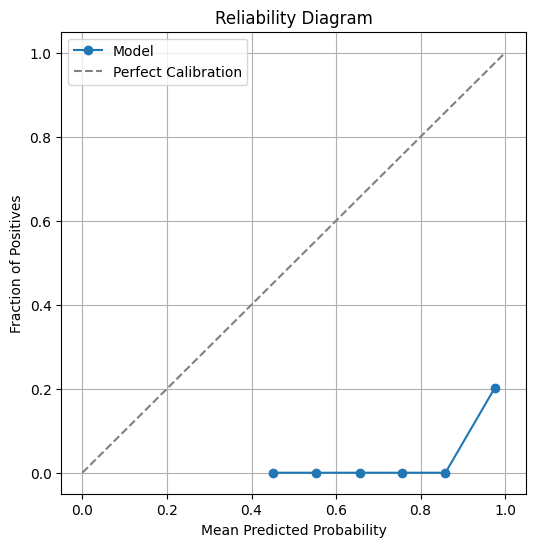

Accuracy:                     0.1708
Precision:                    0.1692
Recall:                       1.0000
F1 Score:                     0.2894
Mean Entropy:                 0.1616
Mean Max Probability:         0.9490
Expected Calibration Error:   0.7800
Confusion Matrix:
[[   4 1709]
 [   0  348]]


In [8]:
import os
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Paths and Config ---
ROOT = r"/home/msi/Documents/IIT-H/src"
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks_all")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks_all")
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier_mask_only.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8

# --- Dataset ---
class MaskOnlyDataset(Dataset):
    def __init__(self, mask_dir, label, transform=None):
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mask_filename = self.files[idx]
        mask_path = os.path.join(self.mask_dir, mask_filename)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        if self.transform:
            mask = Image.fromarray(mask).resize(input_size)
            mask = self.transform(mask)

        y = torch.tensor([self.label], dtype=torch.float32)
        return mask, y

# --- Transform ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoader ---
good_dataset = MaskOnlyDataset(GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = MaskOnlyDataset(BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset
val_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# --- Load Model ---
def get_mask_model():
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    orig_conv = model.conv1
    model.conv1 = torch.nn.Conv2d(1, orig_conv.out_channels,
                                  kernel_size=orig_conv.kernel_size,
                                  stride=orig_conv.stride,
                                  padding=orig_conv.padding,
                                  bias=orig_conv.bias)
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(SAVED_CLASSIFIER_PATH, map_location=device))
    model.to(device).eval()
    return model

model = get_mask_model()

# --- Evaluation Loop ---
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y_batch.squeeze().cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Compute Metrics ---
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Entropy calculation
def compute_entropy(probs):
    epsilon = 1e-12
    probs = np.clip(probs, epsilon, 1 - epsilon)
    return - (probs * np.log(probs) + (1 - probs) * np.log(1 - probs))

entropies = compute_entropy(all_probs)
mean_entropy = entropies.mean()

# Max probability (confidence)
max_probs = np.maximum(all_probs, 1 - all_probs)
mean_max_prob = max_probs.mean()

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.show()

# Expected Calibration Error (ECE)
def expected_calibration_error(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(probs, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:
            bin_prob_mean = probs[bin_mask].mean()
            bin_acc = labels[bin_mask].mean()
            bin_weight = np.sum(bin_mask) / len(probs)
            ece += np.abs(bin_prob_mean - bin_acc) * bin_weight
    return ece

ece = expected_calibration_error(all_probs, all_labels, n_bins=10)

# --- Print Results ---
print(f"Accuracy:                     {accuracy:.4f}")
print(f"Precision:                    {precision:.4f}")
print(f"Recall:                       {recall:.4f}")
print(f"F1 Score:                     {f1:.4f}")
print(f"Mean Entropy:                 {mean_entropy:.4f}")
print(f"Mean Max Probability:         {mean_max_prob:.4f}")
print(f"Expected Calibration Error:   {ece:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
